In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import zipfile
import requests
import pandas as pd

# Create directory structure
os.makedirs('RealWaste_split', exist_ok=True)
os.makedirs('RealWaste_split/train', exist_ok=True)
os.makedirs('RealWaste_split/val', exist_ok=True)
os.makedirs('RealWaste_split/test', exist_ok=True)

# Since we don't have direct download link, you'll need to:
# 1. Download from https://archive.ics.uci.edu/dataset/891/realwaste
# 2. Extract and organize into class folders

In [2]:
def create_custom_cnn(input_shape=(224, 224, 3), num_classes=9):
    """
    Create a custom CNN for RealWaste classification
    """
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block  
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
custom_model = create_custom_cnn()
custom_model.summary()

c:\Users\acer\EN3150-CNN-for-Image-Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,396,937 (73.99 MB)

 Trainable params: 19,396,937 (73.99 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you've organized data into train/val/test folders by class
train_generator = train_datagen.flow_from_directory(
    'RealWaste_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'RealWaste_split/val', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'RealWaste_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3323 images belonging to 9 classes.
Found 710 images belonging to 9 classes.
Found 719 images belonging to 9 classes.


In [5]:
def train_with_optimizer(optimizer, optimizer_name):
    """Train model with specific optimizer and return history"""
    model = create_custom_cnn()
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        verbose=1
    )
    
    return model, history

# Compare different optimizers
optimizers = {
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'SGD': keras.optimizers.SGD(learning_rate=0.01),
    'SGD_Momentum': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
}

results = {}
for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name}...")
    model, history = train_with_optimizer(optimizer, opt_name)
    results[opt_name] = {'model': model, 'history': history}


Training with Adam...


c:\Users\acer\EN3150-CNN-for-Image-Classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.1872 - loss: 2.1717 - val_accuracy: 0.2634 - val_loss: 2.1558
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.2708 - loss: 2.0080 - val_accuracy: 0.3183 - val_loss: 1.8210
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.3067 - loss: 1.8689 - val_accuracy: 0.3549 - val_loss: 1.7728
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.3732 - loss: 1.6886 - val_accuracy: 0.3380 - val_loss: 1.6920
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.4180 - loss: 1.5879 - val_accuracy: 0.4620 - val_loss: 1.5146
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.4574 - loss: 1.5312 - val_accuracy: 0.4521 - val_loss: 1.4859
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.4890 - loss: 1.4221 - val_accuracy: 0.4817 - val_loss: 1.4226
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.4863 - loss: 1.3906 - val_accu

Testing different learning rates...

Testing LR: 1e-05
Validation Loss: 1.9273, Accuracy: 0.3099

Testing LR: 5e-05
Validation Loss: 1.9806, Accuracy: 0.2930

Testing LR: 0.0001
Validation Loss: 2.0105, Accuracy: 0.2732

Testing LR: 0.0005
Validation Loss: 1.7289, Accuracy: 0.4028

Testing LR: 0.001
Validation Loss: 1.7890, Accuracy: 0.4113

Testing LR: 0.005
Validation Loss: 2.1410, Accuracy: 0.1944

Testing LR: 0.01
Validation Loss: 2.1410, Accuracy: 0.1944


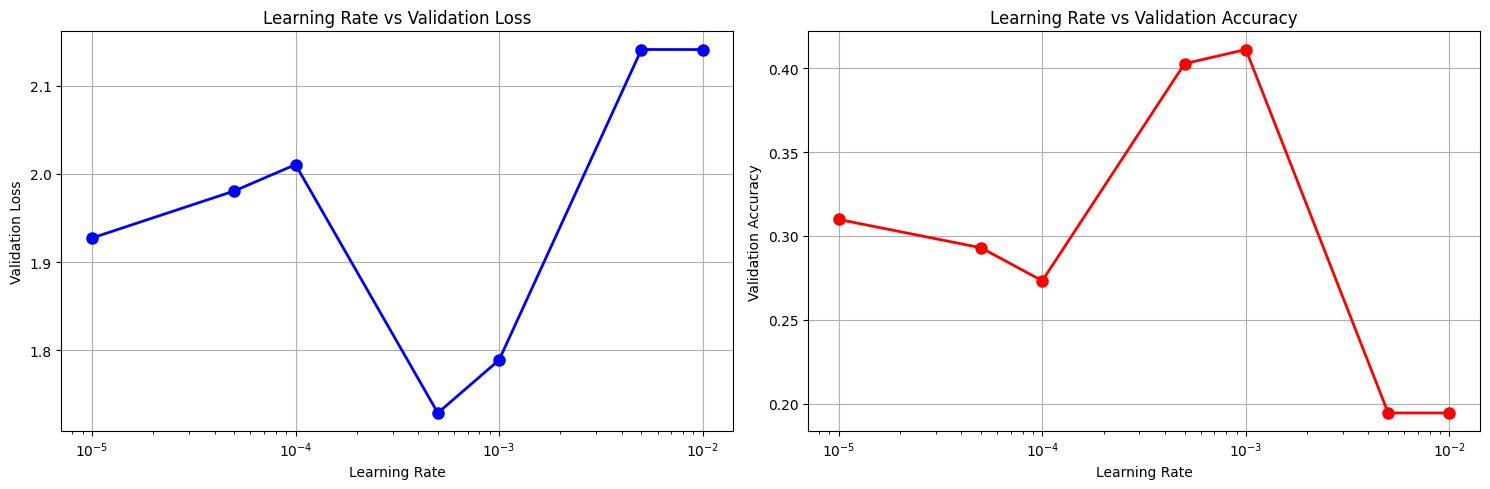


🎯 Recommended learning rate: 0.0005
   Validation Loss: 1.7289
   Validation Accuracy: 0.4028


In [7]:
# Method 1: Simple and reliable learning rate test
def simple_learning_rate_test():
    """Test different learning rates and find the optimal one"""
    
    learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
    val_losses = []
    val_accuracies = []
    
    print("Testing different learning rates...")
    
    for lr in learning_rates:
        print(f"\nTesting LR: {lr}")
        
        # Create a fresh model for each learning rate
        model = keras.Sequential([
            keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
            keras.layers.MaxPooling2D((2,2)),
            keras.layers.Conv2D(64, (3,3), activation='relu'),
            keras.layers.MaxPooling2D((2,2)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(9, activation='softmax')
        ])
        
        # Compile with current learning rate
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Train for a few epochs to see convergence
        history = model.fit(
            train_generator,
            epochs=5,  # Reduced for speed
            validation_data=val_generator,
            verbose=0
        )
        
        # Record final validation loss and accuracy
        final_val_loss = history.history['val_loss'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        
        val_losses.append(final_val_loss)
        val_accuracies.append(final_val_acc)
        
        print(f"Validation Loss: {final_val_loss:.4f}, Accuracy: {final_val_acc:.4f}")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.semilogx(learning_rates, val_losses, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Validation Loss')
    ax1.set_title('Learning Rate vs Validation Loss')
    ax1.grid(True)
    
    # Plot accuracy
    ax2.semilogx(learning_rates, val_accuracies, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Learning Rate')
    ax2.set_ylabel('Validation Accuracy')
    ax2.set_title('Learning Rate vs Validation Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal learning rate (lowest loss)
    optimal_idx = np.argmin(val_losses)
    optimal_lr = learning_rates[optimal_idx]
    
    print(f"\n🎯 Recommended learning rate: {optimal_lr}")
    print(f"   Validation Loss: {val_losses[optimal_idx]:.4f}")
    print(f"   Validation Accuracy: {val_accuracies[optimal_idx]:.4f}")
    
    return optimal_lr

# Run the simple learning rate test
optimal_lr = simple_learning_rate_test()

In [8]:
def create_pretrained_model(model_name='VGG16', num_classes=9):
    """Create pre-trained model for transfer learning"""
    
    if model_name == 'VGG16':
        base_model = keras.applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    elif model_name == 'ResNet50':
        base_model = keras.applications.ResNet50(
            weights='imagenet', 
            include_top=False,
            input_shape=(224, 224, 3)
        )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classifier
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Fine-tune pre-trained models
pretrained_models = {}
for model_name in ['VGG16', 'ResNet50']:
    print(f"\nFine-tuning {model_name}...")
    model = create_pretrained_model(model_name)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        verbose=1
    )
    
    pretrained_models[model_name] = {'model': model, 'history': history}


Fine-tuning VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 152s 3us/step
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 554s 5s/step - accuracy: 0.3181 - loss: 1.9013 - val_accuracy: 0.4169 - val_loss: 1.5951
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 551s 5s/step - accuracy: 0.4351 - loss: 1.5591 - val_accuracy: 0.4704 - val_loss: 1.4356
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 637s 6s/step - accuracy: 0.4860 - loss: 1.4194 - val_accuracy: 0.5451 - val_loss: 1.2989
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 691s 7s/step - accuracy: 0.5191 - loss: 1.3319 - val_accuracy: 0.5451 - val_loss: 1.2387
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 596s 6s/step - accuracy: 0.5435 - loss: 1.2766 - val_accuracy: 0.5521 - val_loss: 1.1952
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 609s 6s/step - accuracy: 0.5697 - loss: 1.2219 - val_accuracy: 0.6169 - val_loss: 1.1103
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 593s 6s/step - accuracy: 0.5943 - loss: 1.1671 - val_accuracy: 0.6014 - val_loss: 1.1101
Epoch 8/20
104/104 ━━━

c:\Users\acer\EN3150-CNN-for-Image-Classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 613ms/step

Custom CNN (Adam) Results:
Test Accuracy: 0.6356
Test Loss: 1.0223


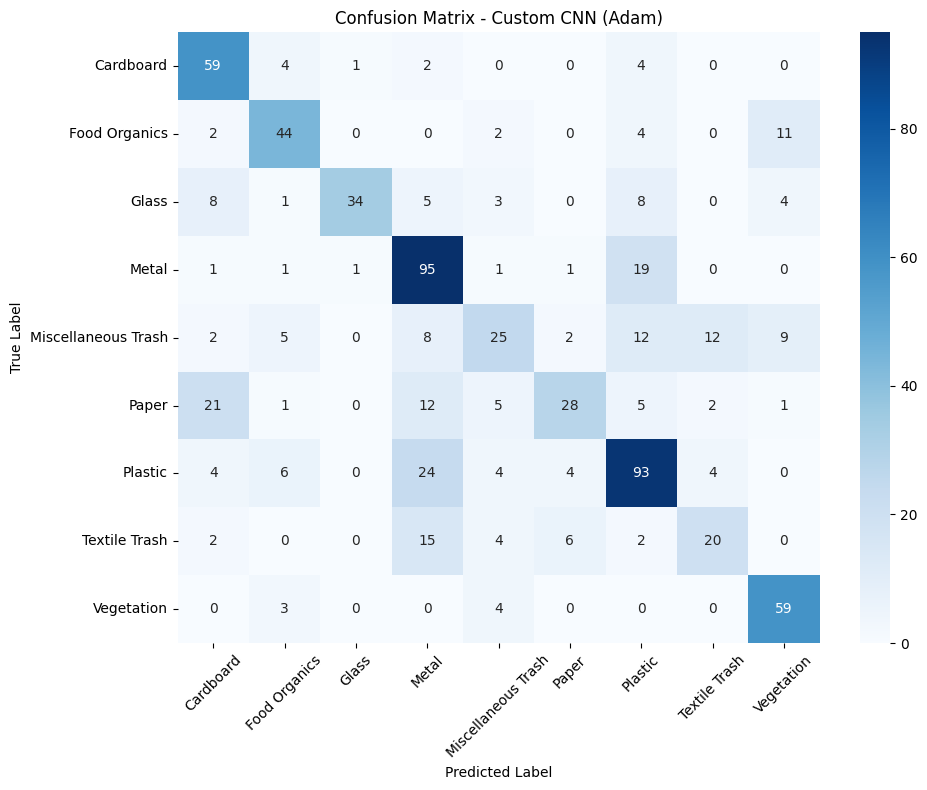

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step

Custom CNN (SGD) Results:
Test Accuracy: 0.4715
Test Loss: 1.4642


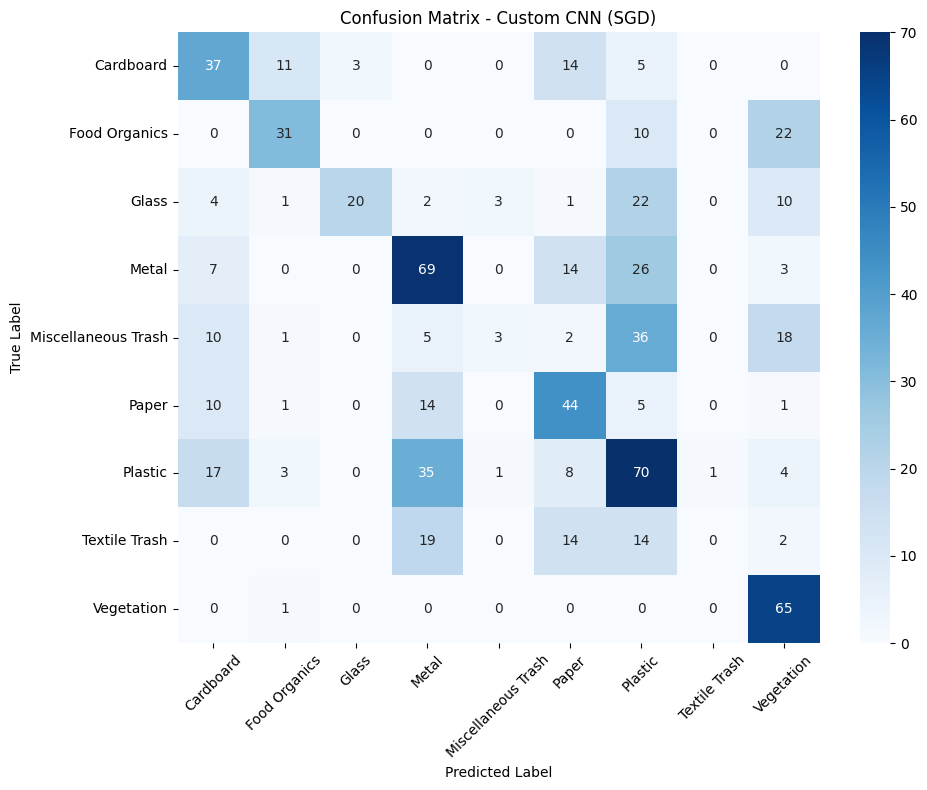

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step

Custom CNN (SGD_Momentum) Results:
Test Accuracy: 0.5035
Test Loss: 1.3845


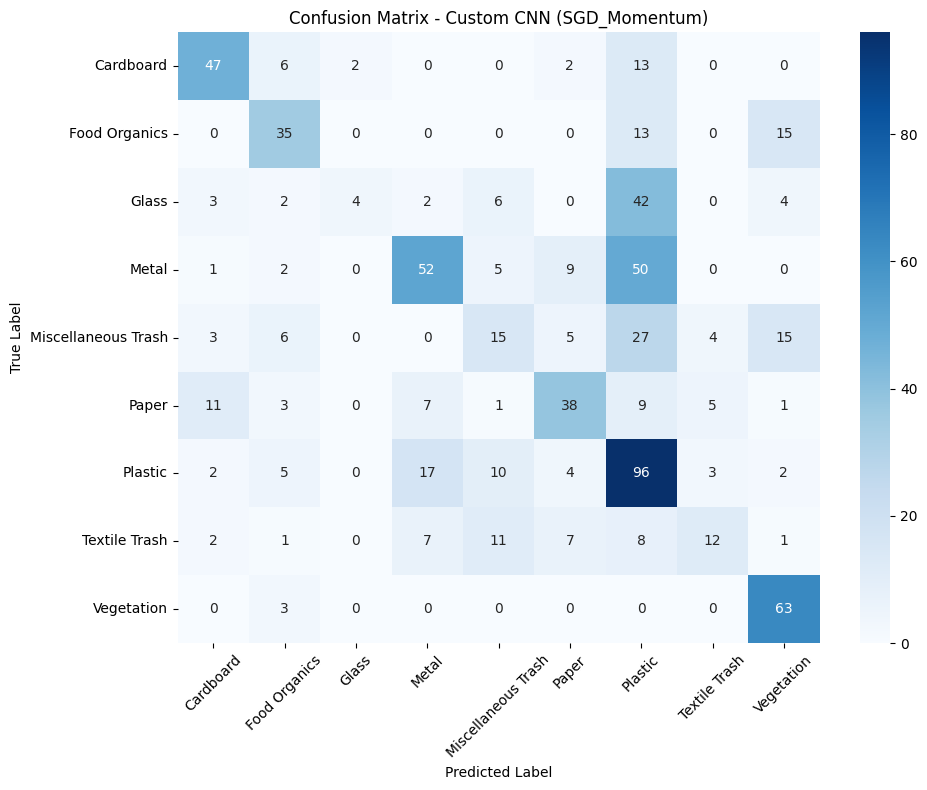

23/23 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step

Pre-trained VGG16 Results:
Test Accuracy: 0.7093
Test Loss: 0.8027


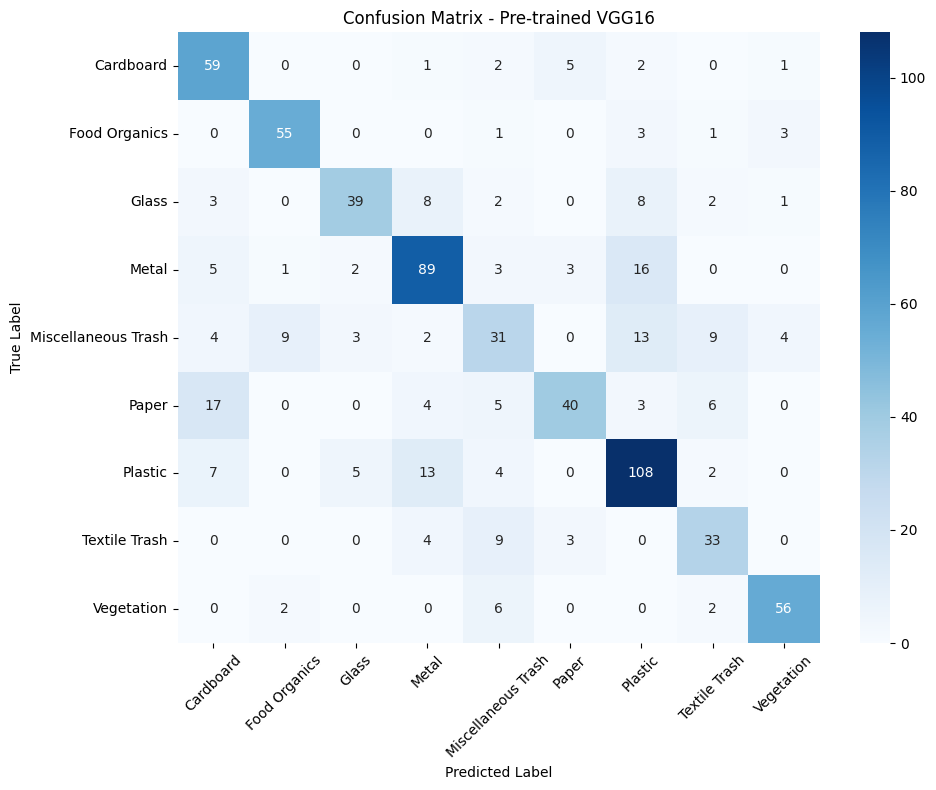

23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step


c:\Users\acer\EN3150-CNN-for-Image-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\acer\EN3150-CNN-for-Image-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\acer\EN3150-CNN-for-Image-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Pre-trained ResNet50 Results:
Test Accuracy: 0.3241
Test Loss: 1.9002


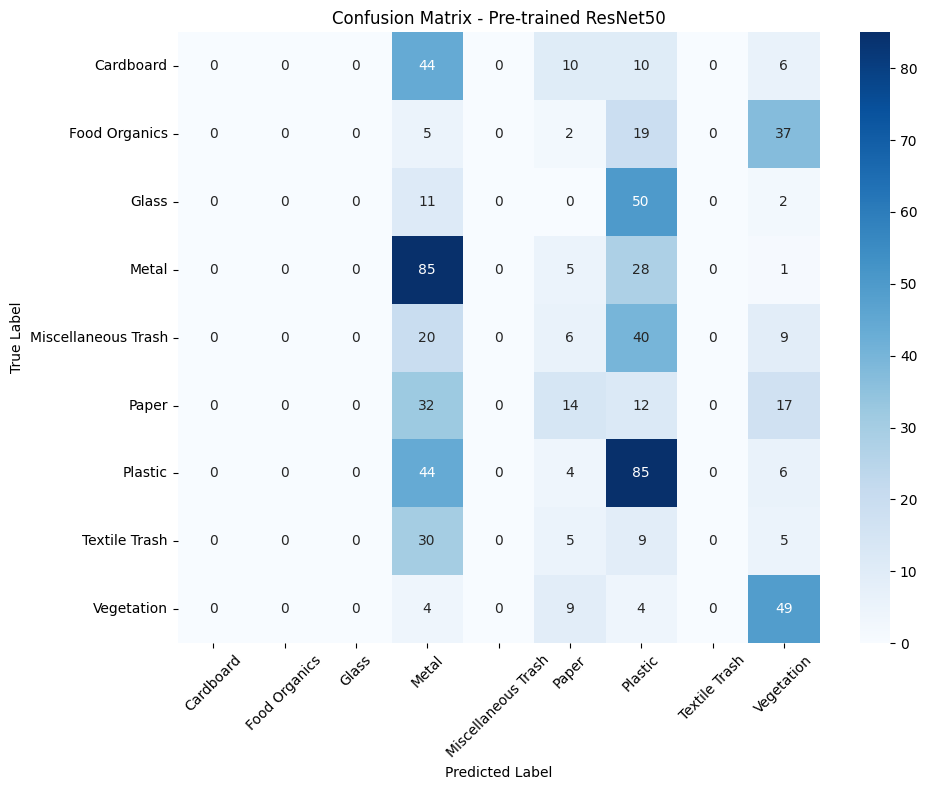

In [9]:
def evaluate_model(model, test_generator, model_name):
    """Comprehensive model evaluation"""
    # Predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    # Metrics
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Classification Report
    class_names = list(test_generator.class_indices.keys())
    cr = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
    
    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': test_accuracy,
        'loss': test_loss,
        'confusion_matrix': cm,
        'classification_report': cr
    }

# Evaluate all models
evaluation_results = {}

# Custom CNN with different optimizers
for opt_name in results.keys():
    evaluation_results[opt_name] = evaluate_model(
        results[opt_name]['model'], test_generator, f"Custom CNN ({opt_name})"
    )

# Pre-trained models
for model_name in pretrained_models.keys():
    evaluation_results[model_name] = evaluate_model(
        pretrained_models[model_name]['model'], test_generator, f"Pre-trained {model_name}"
    )